### Generating Overfit Tree Models

By default, you scikitlearn tree models will grow until every node is pure.  To explore this, you are to build different models using the `max_depth` parameter and determine when the tree begins to overfit the data.  For depths from `max_depth = 1` until the tree is completed, keep track of the accuracy on training vs. test data and generate a plot with depths as the horizontal axis and accuracy as the vertical axis for train and test data.  

Repeat this process with different splits of the data to determine at what depth the tree begins to overfit.  Share your results with your peers and discuss your approach to generating the visualization.  What are the consequences of this overfitting for your approach to building Decision Trees?   We provide a small dataset with health data where your goal is to predict whether or not the individuals survive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
data = pd.read_csv('data/Whickham.txt')

In [3]:
data.head()

outcome smoker  age
0   Alive    Yes   23
1   Alive    Yes   18
2    Dead    Yes   71
3   Alive     No   67
4   Alive     No   64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  1314 non-null   object
 1   smoker   1314 non-null   object
 2   age      1314 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


In [5]:
data.groupby(['smoker', 'age']).agg(pd.Series.mode)

outcome
smoker age        
No     18    Alive
       19    Alive
       20    Alive
       21    Alive
       22    Alive
...            ...
Yes    80     Dead
       81     Dead
       82     Dead
       83     Dead
       84     Dead

[133 rows x 1 columns]

## Feature Overlapping
It is a small dataset, there are 72 feature overlapping for 2 different classes

In [6]:
# number of overlapping feature with different classes
data_size = data.groupby(['smoker', 'age', 'outcome']).size().groupby(['smoker', 'age']).size().reset_index()
data_size[data_size[0]>1]

smoker  age  0
0       No   18  2
9       No   27  2
11      No   29  2
14      No   32  2
15      No   33  2
..     ...  ... ..
113    Yes   64  2
115    Yes   66  2
116    Yes   67  2
120    Yes   71  2
123    Yes   74  2

[72 rows x 3 columns]

In [7]:
data_size = data.groupby(['smoker', 'age', 'outcome']).size().reset_index(name='cnt')
data_size

smoker  age outcome  cnt
0       No   18   Alive   10
1       No   18    Dead    1
2       No   19   Alive    8
3       No   20   Alive   11
4       No   21   Alive    8
..     ...  ...     ...  ...
200    Yes   80    Dead    1
201    Yes   81    Dead    3
202    Yes   82    Dead    3
203    Yes   83    Dead    1
204    Yes   84    Dead    1

[205 rows x 4 columns]

In [8]:
data_size = data_size[['smoker', 'age', 'cnt']].groupby(['smoker', 'age']).agg(['sum', 'size']).reset_index()
data_size.columns = ['smoker', 'age', 'sum', 'size']
data_size

smoker  age  sum  size
0       No   18   11     2
1       No   19    8     1
2       No   20   11     1
3       No   21    8     1
4       No   22    8     1
..     ...  ...  ...   ...
128    Yes   80    1     1
129    Yes   81    3     1
130    Yes   82    3     1
131    Yes   83    1     1
132    Yes   84    1     1

[133 rows x 4 columns]

In [9]:
#data_size[data_size['size']>1]

In [10]:
data_size[data_size['size']>1]['sum']

0      11
9      20
11      9
14     16
15     16
       ..
113    10
115     6
116     3
120     8
123     3
Name: sum, Length: 72, dtype: int64

In [11]:
# percent of data?
sum(data_size[data_size['size']>1]['sum'])/len(data)

0.621765601217656

In [12]:
data.describe()

age
count  1314.000000
mean     46.920091
std      17.432027
min      18.000000
25%      32.000000
50%      46.000000
75%      61.000000
max      84.000000

## Separate Target Column
Separating the target column.

In [13]:
# X, y
X = data[['smoker', 'age']].copy()
y = data['outcome']

In [14]:
# entropy
# -0.31 * np.log2(0.31) - 0.33 * np.log2(0.33) - 0.36 * np.log2(0.36)

### Data Transformation and Balance
Make smoker 1/0 and check if it is balanced dataset.

In [15]:
X['smoker'].value_counts(normalize=True)

No     0.557078
Yes    0.442922
Name: smoker, dtype: float64

In [16]:
y.value_counts(normalize=True)

Alive    0.719178
Dead     0.280822
Name: outcome, dtype: float64

In [17]:
#X.loc[:, 'smoker']

In [18]:
# make smoker 1/0 
X.loc[:, 'smoker'] = X['smoker'].replace({'Yes':1,'No':0})

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   smoker  1314 non-null   int64
 1   age     1314 non-null   int64
dtypes: int64(2)
memory usage: 20.7 KB


## Split Dataset
All columns are numeric, just split the dataset, the target column is alredy spearated.

In [20]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, test_size = 0.3, stratify = y)

## Create a Model
Create a data model and get maximum depth of the decision tree so it can be the upper boundry in the brute force approach below

In [21]:
# get maximum depth with default parameters:
max_tree = DecisionTreeClassifier(random_state=93).fit(X_train, y_train)
max_depth = max_tree.get_depth()
max_depth

10

## Iterate DecisionTreeClassifier with max_depth=d Parameter
Iterate over for-loop from 1 to the upper bound set above to compute scores 

In [22]:
# Try out all depths to capture scores
train_accs = []
test_accs = []
for d in range(1,max_depth+1,1):
    #create decision tree and fit it
    tree = DecisionTreeClassifier(random_state=93, max_depth=d).fit(X_train, y_train)
    # populate train and test accuracy lists
    train_accs.append(tree.score(X_train, y_train))
    test_accs.append(tree.score(X_test, y_test))

In [23]:
test_accs

[0.8379746835443038,
 0.8379746835443038,
 0.8278481012658228,
 0.8278481012658228,
 0.8354430379746836,
 0.8253164556962025,
 0.8151898734177215,
 0.8151898734177215,
 0.8151898734177215,
 0.8151898734177215]

## Plot the Graph and Highlight Best Score
Scores compted per iteration and just plot the train and test scores to compare and highlight the best outcome!

Text(0.5, 1.0, 'Tree Depth vs. Train/Test Scores')

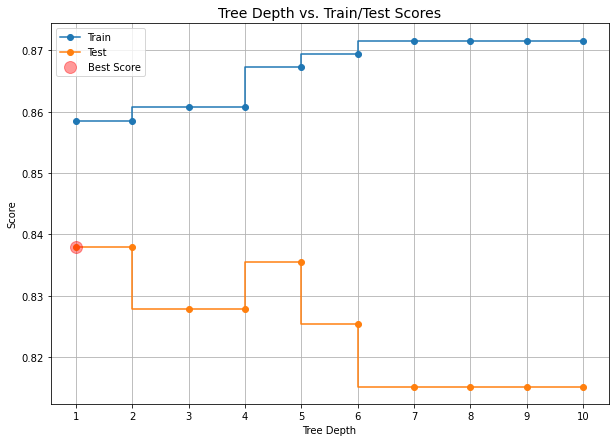

In [24]:
# plot scores
plt.subplots(figsize = (10, 7))
plt.step(range(1,max_depth+1,1), train_accs, '-o', label = 'Train')
plt.step(range(1,max_depth+1,1), test_accs, '-o', label = 'Test')
plt.plot(np.argmax(test_accs)+1, max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Score')
plt.xticks(range(1,max_depth+1,1), rotation = 0)
plt.legend()
plt.grid()
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Tree Depth vs. Train/Test Scores', fontsize=14)

In [25]:
# create and fit optimum max_depth=np.argmax(test_accs)+1
optimum_tree = DecisionTreeClassifier(random_state=93, max_depth = np.argmax(test_accs)+1).fit(X_train, y_train)

In [26]:
plt.subplots(figsize = (30, 30), dpi=600)
plot_tree(max_tree, filled=True, feature_names=X.columns, class_names=['Alive', 'Dead'])

[Text(0.6520066624365483, 0.9545454545454546, 'age <= 64.5\ngini = 0.404\nsamples = 919\nvalue = [661, 258]\nclass = Alive'),
 Text(0.3865006345177665, 0.8636363636363636, 'age <= 44.5\ngini = 0.243\nsamples = 741\nvalue = [636, 105]\nclass = Alive'),
 Text(0.17385786802030456, 0.7727272727272727, 'age <= 37.5\ngini = 0.086\nsamples = 423\nvalue = [404, 19]\nclass = Alive'),
 Text(0.10406091370558376, 0.6818181818181818, 'age <= 35.5\ngini = 0.042\nsamples = 325\nvalue = [318, 7]\nclass = Alive'),
 Text(0.05583756345177665, 0.5909090909090909, 'smoker <= 0.5\ngini = 0.034\nsamples = 290\nvalue = [285, 5]\nclass = Alive'),
 Text(0.02030456852791878, 0.5, 'age <= 31.5\ngini = 0.012\nsamples = 162\nvalue = [161, 1]\nclass = Alive'),
 Text(0.01015228426395939, 0.4090909090909091, 'gini = 0.0\nsamples = 117\nvalue = [117, 0]\nclass = Alive'),
 Text(0.030456852791878174, 0.4090909090909091, 'age <= 32.5\ngini = 0.043\nsamples = 45\nvalue = [44, 1]\nclass = Alive'),
 Text(0.02030456852791878,

[Text(0.5, 0.75, 'age <= 64.5\ngini = 0.404\nsamples = 919\nvalue = [661, 258]\nclass = Alive'),
 Text(0.25, 0.25, 'gini = 0.243\nsamples = 741\nvalue = [636, 105]\nclass = Alive'),
 Text(0.75, 0.25, 'gini = 0.241\nsamples = 178\nvalue = [25, 153]\nclass = Dead')]

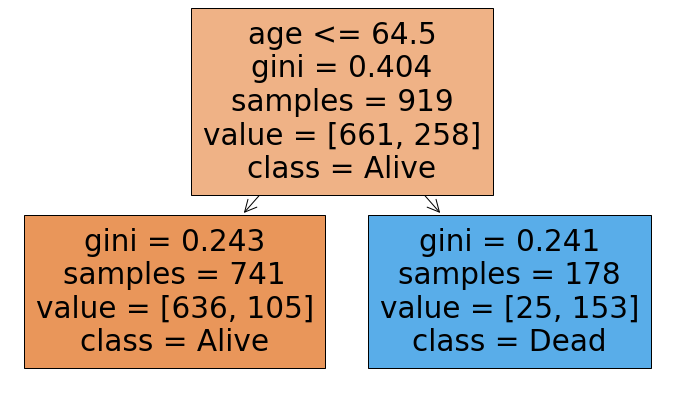

In [27]:
plt.subplots(figsize = (12, 7))
plot_tree(optimum_tree, filled=True, feature_names=X.columns, class_names=['Alive', 'Dead'])
#plt.show()

Text(0.5, 1.0, 'Optimized Tree @ 1 Level(s)')

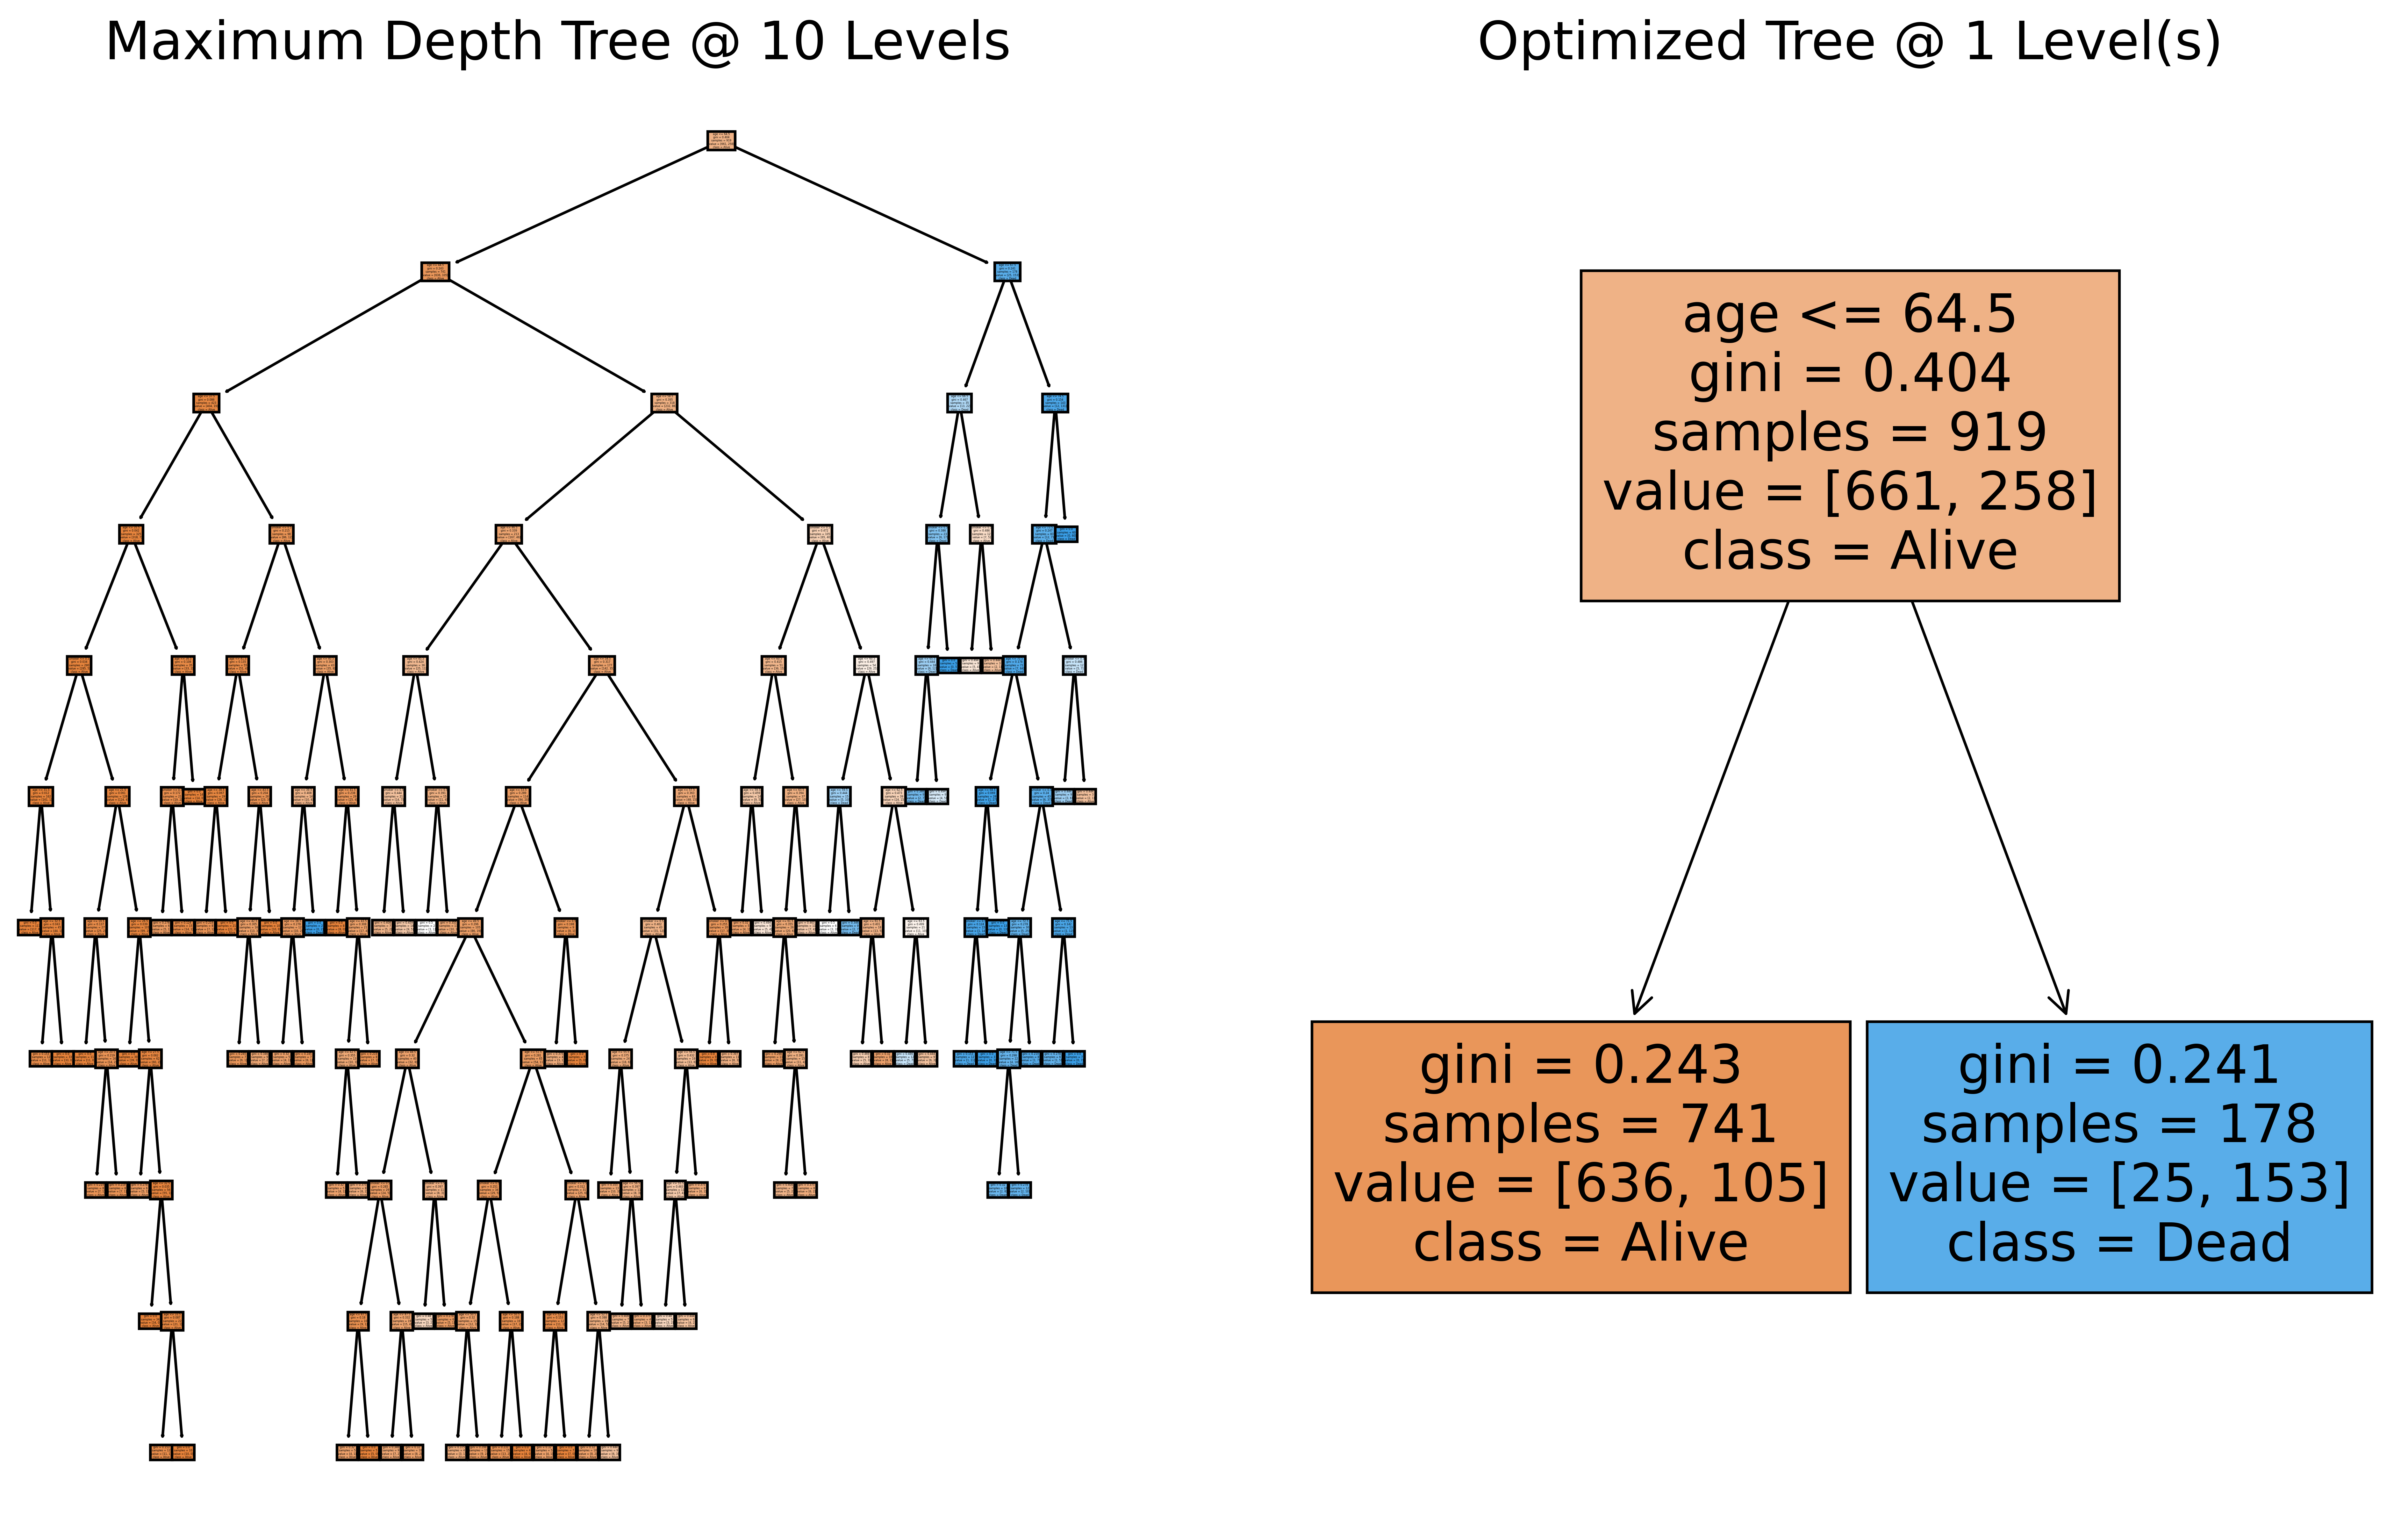

In [28]:
fig, ax = plt.subplots(1,2, figsize = (16, 10), dpi=600)
plot_tree(max_tree, ax = ax[0], filled = True, feature_names = X.columns, class_names=['Alive', 'Dead'])
ax[0].set_title(f'Maximum Depth Tree @ {max_depth} Levels', fontsize = 20)
plot_tree(optimum_tree, ax = ax[1], filled = True, feature_names = X.columns, class_names=['Alive', 'Dead'])
ax[1].set_title(f'Optimized Tree @ {np.argmax(test_accs)+1} Level(s)', fontsize = 20)
#plt.show()

In [29]:
#data.groupby(['smoker', 'age', 'outcome']).size().groupby(['smoker', 'age']).size()
#data_size = data_size[data_size[0]>1]


In [30]:
data_size.loc[:, 'smoker'] = data_size['smoker'].replace({'Yes':1,'No':0})

In [31]:
data_size

smoker  age  sum  size
0         0   18   11     2
1         0   19    8     1
2         0   20   11     1
3         0   21    8     1
4         0   22    8     1
..      ...  ...  ...   ...
128       1   80    1     1
129       1   81    3     1
130       1   82    3     1
131       1   83    1     1
132       1   84    1     1

[133 rows x 4 columns]

In [32]:
c=y.replace({'Alive':1,'Dead':0})


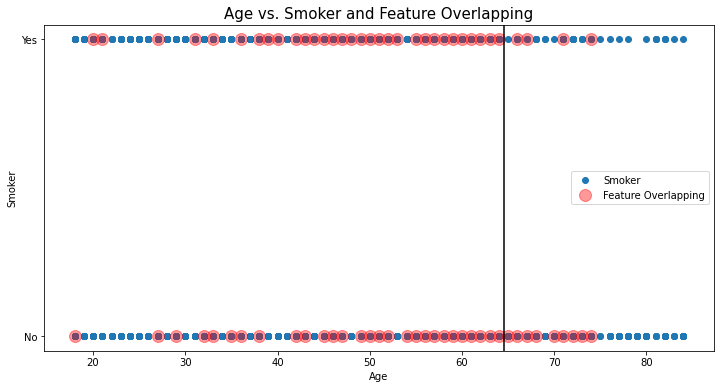

In [33]:
# plot
fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(X['age'], X['smoker'], 'o', label = 'Smoker')
plt.plot(data_size[data_size['size']>1]['age'], data_size[data_size['size']>1]['smoker'],
         'ro', markersize = 12, alpha = 0.4, label = 'Feature Overlapping')
#plot the split point
plt.axvline(x=64.50, color="black")
# Set Y ticks and labels
ax.set_yticks((0, 1))
ax.set_yticklabels(('No','Yes'))
plt.xlabel('Age')
plt.ylabel('Smoker')
plt.title('Age vs. Smoker and Feature Overlapping', fontsize=15)
plt.legend()
plt.show()